In [ ]:
# The cache directories:
cache_path       = '/data/crcns2021'
image_cache_path = f'{cache_path}/annot-images'
v123_cache_path  = f'{cache_path}/annot-v123'
csulc_cache_path = f'{cache_path}/annot-csulc'
trace_save_path = f'{cache_path}/results/data_branch/save'
labels_path = f'{cache_path}/results/labels'

import os
# If you aren't using /data
os.environ['HCPANNOT_LOAD_PATH'] = cache_path

In [ ]:
import os 
import sys
sys.path.append('..')
import numpy as np
import neuropythy as ny
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import logging
%matplotlib inline
%load_ext autoreload
%autoreload 2

## figure setting
For some reason the only font family I could found was serif.

In [3]:
import pylab as pl
la = pl.matplotlib.font_manager.FontManager()
lu = pl.matplotlib.font_manager.FontProperties(family = 'monospace')
la.findfont(lu)

'/home/jiyeongha/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf'

In [4]:
import matplotlib as mpl
# Additional matplotlib preferences:
font_data = {'size': 10,
             'weight': 'light',
            'family': 'monospace'} # missing fonts 
mpl.rc('font', **font_data) 
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72 * 2
mpl.rcParams['savefig.dpi'] = 72 * 4

In [5]:
# Now we can import the hcp-annot-vc library.
import hcpannot
hcpannot.interface.default_load_path = cache_path  
from hcpannot import (vc_plan, 
                      save_contours, 
                      load_contours,
                      subject_ids)

In [6]:
rater_list = ['BrendaQiu',
              'bogengsong',
              'JiyeongHa',
              'lindazelinzhao',
              'nourahboujaber',
              'jennifertepan']

## Helper functions for plotting mean contours across subjects

In [22]:
def load_cortex(subject, hemi):
    cortex = ny.data['hcp_lines'].subjects[subject].hemis[hemi] #cortex object
    return cortex

def roi_trace_to_path(dat, cortex, roi, hemi):
    # grab a trace
    trace = dat['traces'][roi]
    # get the subject's hemisphere mesh
    path = trace.to_path(cortex)
    return path
    
def get_path_coords_in_fsaverage(path, cortex):
    fmap = ny.to_flatmap('occipital_pole', cortex)
    fsa_coords = fmap.unaddress(path.addresses)
    return fsa_coords

def normalize_coords(fsa_coords, n_points=800):
    curve = ny.util.CurveSpline(fsa_coords)
    normed_fsa_coords = curve.linspace(n_points)
    return normed_fsa_coords

def arrange_multiple_coords_into_dict(normed_x_list, 
                                      normed_y_list, 
                                      normed_fsa_coords_keys=None, 
                                      average=True):
    if normed_fsa_coords_keys is None:
        normed_fsa_coords_keys = np.range(0, len(normed_fsa_coords_list))
    normed_fsa_coords_vals = [np.asarray((x,y)) for x, y in zip(normed_x_list, normed_y_list)]  
    normed_fsa_coords_dict = dict(zip(normed_fsa_coords_keys, normed_fsa_coords_vals))
    if average is True:
        avg_x = np.mean(normed_x_list, axis=0)
        avg_y = np.mean(normed_y_list, axis=0)
        normed_fsa_coords_dict['avg'] = np.asarray((avg_x,avg_y))
    return normed_fsa_coords_dict

def _display_msg(message, verbose):
    if verbose:
        print(message)
    else:
        pass

def main(rater, 
         roi, 
         subject_list, 
         hemi, 
         n_points=800,
         verbose=False,
         average=True,
         trace_save_path=None):
    x_list, y_list = [],[]
    _display_msg(f'**number of subjects: {len(subject_list)}\n**nuber of points:{n_points}', verbose)
        
    for sid in tqdm(subject_list):
        total_start = time.time()
        cache_file = os.path.join(trace_save_path, f"cachesid_{rater}_{sid}_{hemi}_{roi}.mgz")
        if os.path.isfile(cache_file):
            _display_msg(f'found cache data!', verbose)
            (x,y) = ny.load(cache_file)
        else:
            _display_msg(f'---------------------', verbose)
            _display_msg(f'subject no.{sid}', verbose)
            annot = vc_plan(rater=rater, sid=sid, hemisphere=hemi, save_path=trace_save_path)
            _display_msg(f'loading surface mesh....', verbose)
            start = time.time()
            cortex = load_cortex(sid, hemi)
            end = time.time()
            _display_msg(f'done! elpased time is {np.round(end-start,3)} sec.\nNow converting trace to path...', verbose)
            start = time.time()
            path = roi_trace_to_path(annot, cortex, roi, hemi)
            end = time.time()
            _display_msg(f'done! elpased time is {np.round(end-start,3)} sec', verbose)
            _display_msg('Now transforming the path to fsaverage space...', verbose)
            start = time.time()
            fsa_coords = get_path_coords_in_fsaverage(path, cortex)
            end = time.time()
            _display_msg(f'done! elpased time is {np.round(end-start,3)} sec.\nnow interpolating the coordinates..', verbose)
            (x,y) = normalize_coords(fsa_coords, n_points)
            ny.save(cache_file, [x,y])
        x_list.append(x)
        y_list.append(y)
        total_end = time.time()
        _display_msg(f'subject no. {sid} is finished! Total time: {np.round(total_end - total_start,2)} sec', verbose)
    normed_fsa_coords_dict = arrange_multiple_coords_into_dict(x_list, y_list, subject_list, average)
    return normed_fsa_coords_dict


## Plot functions

In [23]:
def plot_multiple_traces(normed_fsa_coords_dict, legend=True, average_only=False, **kwargs):
    title = kwargs.pop('title', None)
    if average_only:
        normed_fsa_coords_dict = {'avg': normed_fsa_coords_dict['avg']}
    n_lines = len(normed_fsa_coords_dict.keys())
    fig, ax = plt.subplots(1,1)
    pal = plt.cm.gist_rainbow(np.linspace(0, 1, n_lines))
    color = iter(pal)
    for k, fsa_coords in normed_fsa_coords_dict.items():
        (x,y) = fsa_coords
        c=next(color)
        if k == 'avg':
            c = 'k'
        ax.plot(x,y, label=str(k), color=c, **kwargs)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=2)
    ax.get_legend().set_visible(legend)
    plt.tight_layout()

## Test

had to fork neuropythy & git clone the fork and pip install -e . and then edit all np.object to object.
Downgrading numpy==1.25.5 or the version listed on the neuropythy document was not successful due to another error on the top importing ipython-related packages

In [24]:
rater = rater_list[0]
normed_fsa_coords_dict = main(rater=rater, 
                              roi='hV4', 
                              subject_list=[100610, 102816], 
                              hemi='lh', 
                              n_points=600, 
                              verbose=True,
                              trace_save_path=trace_save_path)

**number of subjects: 2
**nuber of points:600


  0%|          | 0/2 [00:00<?, ?it/s]

cached! we're just loading in the file...
subject no. 100610 is finished! Total time: 0.0 sec
cached! we're just loading in the file...
subject no. 102816 is finished! Total time: 0.0 sec


## Plot

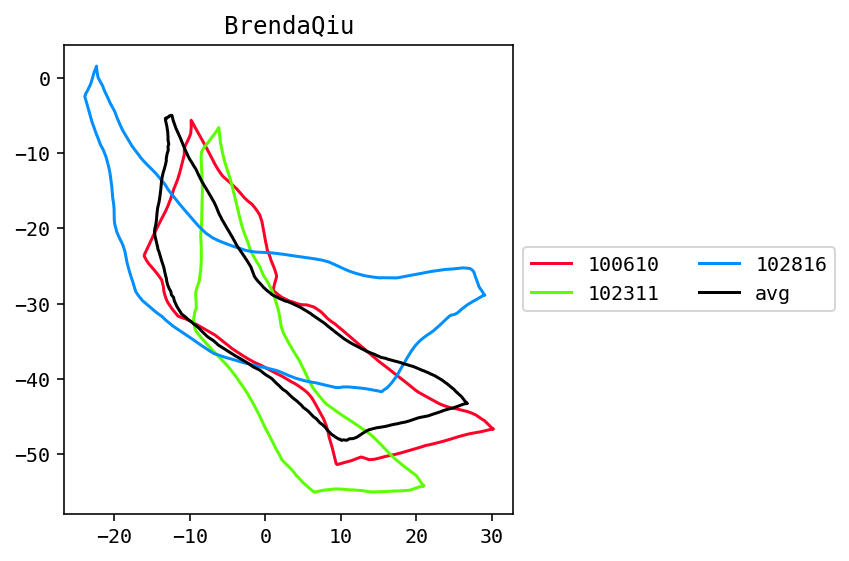

In [13]:
plot_multiple_traces(normed_fsa_coords_dict, 
                     average_only=False, 
                     title=rater)

## for savings..